In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

import fastmri
from fastmri.data import transforms as T

import random

In [2]:
# parameters
slice_idx = 7  # choose which slice in a volume to plot
file_name = "file_brain_AXFLAIR_200_6002447.h5"
gt_file_before_recon_name = './undersampling/' + file_name 
file_after_subsampling_name = './undersampling/r_sub4_' + file_name

## Ground Truth .h5 Basic Format

In [3]:
# ground truth img
# get raw img matrix
gt_hf = h5py.File(gt_file_before_recon_name, 'r')
print('Keys:', list(gt_hf.keys()))  # Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
print('Attrs:', dict(gt_hf.attrs))  # Attrs: ['acquisition', 'max', 'norm', 'patient_id']
print(gt_hf['kspace'][()].shape)  # (number of slices, number of coils, height, width)

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.00041413615952341293, 'norm': 0.08723472457184536, 'patient_id': '30c14259008242f60e5214a793bad574fbf48a7140f76ec3152eef31e090486d'}
(16, 16, 640, 320)


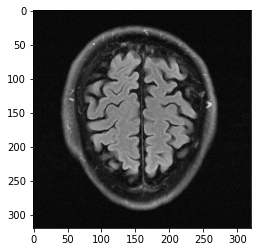

In [4]:
# .h5 contains rss that has already been calculated; same as the cell below
# plot ground truth img (rss)
gt_slice_img_rss_test = gt_hf['reconstruction_rss'][()][slice_idx]
fig = plt.figure()
plt.subplot(1,1,1)
plt.imshow(np.abs(gt_slice_img_rss_test), cmap='gray');

## Subsample Validation Data (equispaced)

In [5]:
# # subsampling

# from fastmri.data.subsample import EquispacedMaskFunc

# mask_func = EquispacedMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object
# gt_volume_kspace = gt_hf['kspace'][()]
# undersample_all_slices_lst = []

# for slice_i in range(gt_volume_kspace.shape[0]):
#     gt_single_slice = T.to_tensor(gt_volume_kspace[slice_i]) # fetch one slice of the sample
#     masked_kspace_single_slice, mask = T.apply_mask(gt_single_slice, mask_func, seed=1)   
#     # Apply the mask to k-space
#     # torch.Size([16, 640, 320, 2]) (number of slices, height, width, 2:real part + imaginary part)
#     masked_kspace_single_slice_complex = masked_kspace_single_slice[..., 0] + \
#                                          masked_kspace_single_slice[..., 1] * 1j
#     undersample_all_slices_lst.append(masked_kspace_single_slice_complex.numpy())

# undersample_all_slices_nparray = np.array(undersample_all_slices_lst)
# print(undersample_all_slices_nparray.shape) # should be the same as the gt_before_recon: (16, 16, 640, 320)


In [6]:
# # create subsampled .h5
# f = h5py.File(file_after_subsampling_name,'w')
# f.create_dataset('ismrmrd_header', data=gt_hf['ismrmrd_header'][()])
# f.create_dataset('kspace', dtype=np.complex64, data=undersample_all_slices_nparray)
# f.create_dataset('mask', dtype=np.float32, data=mask)
# f.attrs['acceleration'] = 8
# f.attrs['acquisition'] = gt_hf.attrs['acquisition']

# num_cols = gt_hf['kspace'][()].shape[-1]
# center_fraction, acceleration = 0.04, 8
# num_low_freqs = int(round(num_cols * center_fraction))
# f.attrs['num_low_frequency'] = num_low_freqs

# f.attrs['patient_id'] = gt_hf.attrs['patient_id']
# f.close()

In [7]:
# # check the format of test data
# test = h5py.File(file_after_subsampling_name, 'r')
# print('Keys:', list(test.keys()))
# print('Attrs:', dict(test.attrs))
# test_kspace = test['kspace'][()]
# print(test_kspace.shape)
# print(test_kspace.dtype)
# print(test['mask'][()].dtype)
# test.close()

## Subsample Validation Data (random)

In [8]:
# subsampling
from fastmri.data.subsample import RandomMaskFunc

mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object
gt_volume_kspace = gt_hf['kspace'][()]
undersample_all_slices_lst = []

for slice_i in range(gt_volume_kspace.shape[0]):
    gt_single_slice = T.to_tensor(gt_volume_kspace[slice_i]) # fetch one slice of the sample
    masked_kspace_single_slice, mask = T.apply_mask(gt_single_slice, mask_func, seed=random.randint(1, 1000))   
    # Apply the mask to k-space
    # torch.Size([16, 640, 320, 2]) (number of slices, height, width, 2:real part + imaginary part)
    masked_kspace_single_slice_complex = masked_kspace_single_slice[..., 0] + \
                                         masked_kspace_single_slice[..., 1] * 1j
    undersample_all_slices_lst.append(masked_kspace_single_slice_complex.numpy())

undersample_all_slices_nparray = np.array(undersample_all_slices_lst)
print(undersample_all_slices_nparray.shape) # should be the same as the gt_before_recon: (16, 16, 640, 320)

(16, 16, 640, 320)


In [9]:
# create subsampled .h5
f = h5py.File(file_after_subsampling_name,'w')
f.create_dataset('ismrmrd_header', data=gt_hf['ismrmrd_header'][()])
f.create_dataset('kspace', dtype=np.complex64, data=undersample_all_slices_nparray)
f.create_dataset('mask', dtype=np.float32, data=mask)
f.attrs['acceleration'] = 4
f.attrs['acquisition'] = gt_hf.attrs['acquisition']

num_cols = gt_hf['kspace'][()].shape[-1]
center_fraction, acceleration = 0.08, 4
num_low_freqs = int(round(num_cols * center_fraction))
f.attrs['num_low_frequency'] = num_low_freqs

f.attrs['patient_id'] = gt_hf.attrs['patient_id']
f.close()

In [10]:
# check the format of test data
test = h5py.File(file_after_subsampling_name, 'r')
print('Keys:', list(test.keys()))
print('Attrs:', dict(test.attrs))
test_kspace = test['kspace'][()]
print(test_kspace.shape)
print(test_kspace.dtype)
print(test['mask'][()].dtype)
test.close()

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 4, 'acquisition': 'AXFLAIR', 'num_low_frequency': 26, 'patient_id': '30c14259008242f60e5214a793bad574fbf48a7140f76ec3152eef31e090486d'}
(16, 16, 640, 320)
complex64
float32
